In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = pd.read_csv('train.csv')

# Análisis Univariado

## Variables cuantitativas

In [33]:
numeric_cols = ['Age', 'SibSp', 'Parch', 'Fare']

In [34]:
from scipy.stats import skew, kurtosis, shapiro

def plot_numeric_distributions(data, numeric_cols):  
    cols_per_row = 2
    n = len(numeric_cols)
    rows = -(-n // cols_per_row)  

    plt.figure(figsize=(cols_per_row * 7, rows * 4))

    for idx, col in enumerate(numeric_cols, 1):
        sk = skew(data[col].dropna())
        kt = kurtosis(data[col].dropna())
        _, p = shapiro(data[col].dropna())

        plt.subplot(rows, cols_per_row*2, idx*2-1)
        sns.histplot(data[col], kde=True, bins=20, color="skyblue")
        plt.title(f"{col}\nSkew: {sk:.2f}, Kurt: {kt:.2f}, p={p:.2g}")

        plt.subplot(rows, cols_per_row*2, idx*2)
        sns.boxplot(y=data[col], color="lightcoral")
        plt.title(f"{col} - Boxplot")

    plt.tight_layout()
    plt.show()

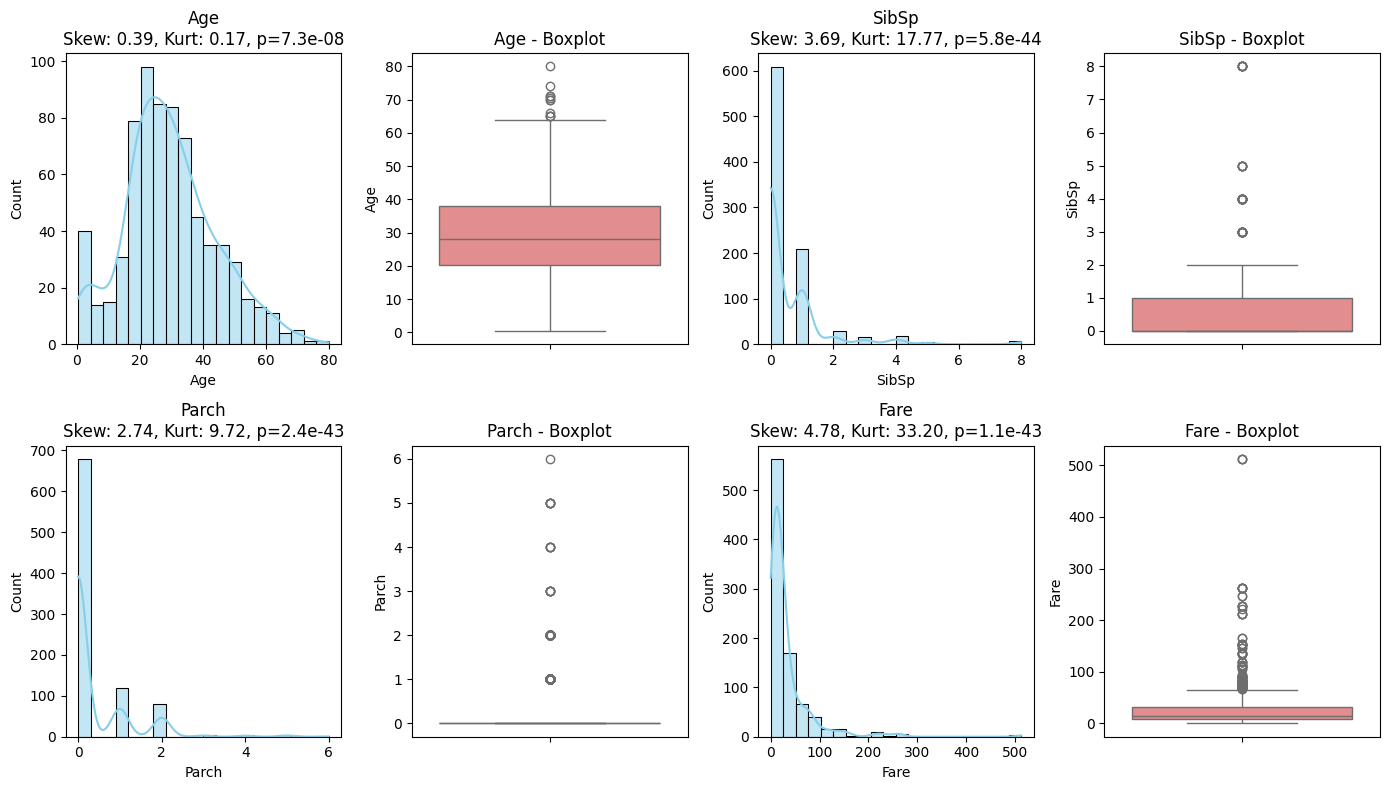

In [35]:
plot_numeric_distributions(data, numeric_cols)

Como primeras observaciones para las variables cuantitativa continuas Age y Fare podemos observar asimetría
positiva en ambos casos, es decir las edades se suelen concentrar en valores
bajos, esto es visualmente claro en el histograma de Fare. Por otro lado, Age
presenta una kurtosis baja mientras que Fare tiene una muy alta. La alta Kurtosis de fare también se puede observar en su boxplot puesto que hay una alta
cantidad de outliers encima del límite superior.

En humano, las tarifas de los pasajeros tienen un sesgo hacia los valores más bajos, por lo que tarifas con precios elevados son raras. Respecto a la edad, esta tiene un ligero sesgo hacia los valores bajos y edades mayores a 65 son atípicas.

## Variables cualitativas

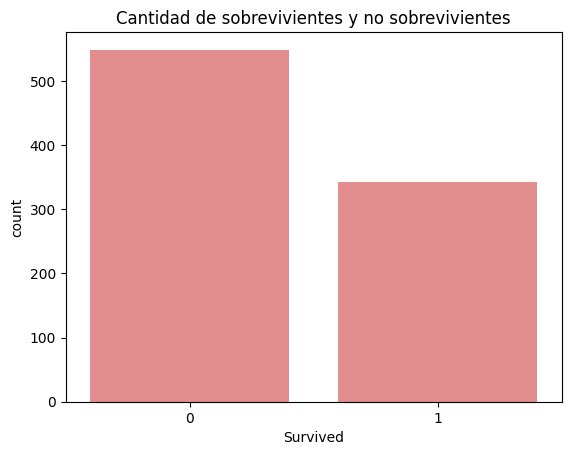

In [42]:
sns.countplot(x='Survived', data=data,color='lightcoral')
plt.title('Cantidad de sobrevivientes y no sobrevivientes')
plt.show()

Observamos que la cantidad de no supervivientes es mayor a la de supervivientes y está un poco desbalanceada

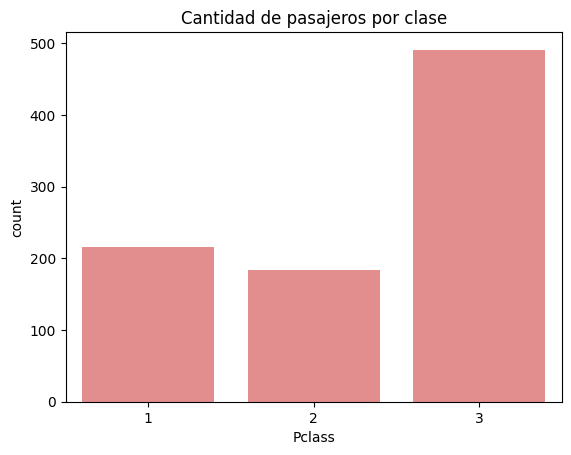

In [45]:
sns.countplot(x='Pclass', data=data, color='lightcoral')
plt.title('Cantidad de pasajeros por clase')
plt.show()

Observamos que la cantidad de pasajeros en tercera clase es mayor.

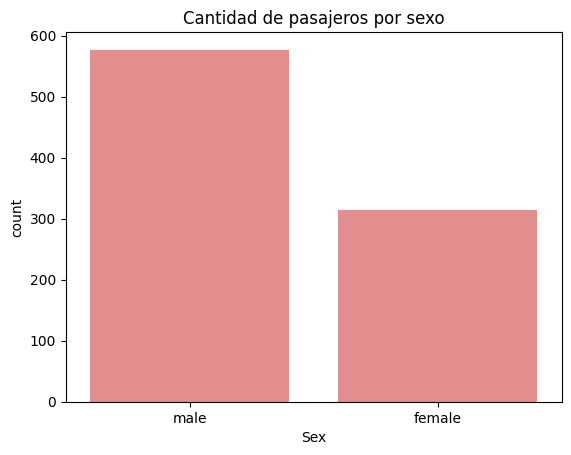

In [47]:
sns.countplot(x='Sex', data=data, color='lightcoral')
plt.title('Cantidad de pasajeros por sexo')
plt.show()

In [52]:
men = len(data[data['Sex']=='male'])/len(data)
women = len(data[data['Sex']=='female'])/len(data)
print(men,women)

0.6475869809203143 0.35241301907968575


Observamos que la cantidad de pasajeros hombres es mayor a la de las mujeres, el 64% son hombres y el 35% mujeres

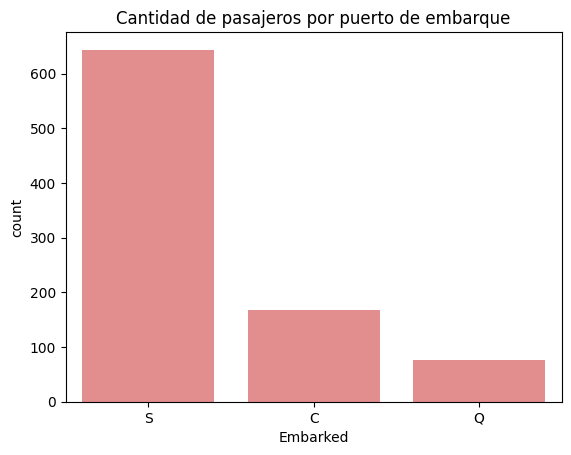

In [54]:
sns.countplot(x='Embarked', data=data, color='lightcoral')
plt.title('Cantidad de pasajeros por puerto de embarque')
plt.show()

La cantidad de pasajeros provenientes del puerto S es bastante mayor a los que provienen del puerto C y Q respectivamente

# Análisis Multivariado

## Multivariado cuantitativas vs cuantitativas

In [57]:
corr_spearman = data[numeric_cols].corr(method='spearman')

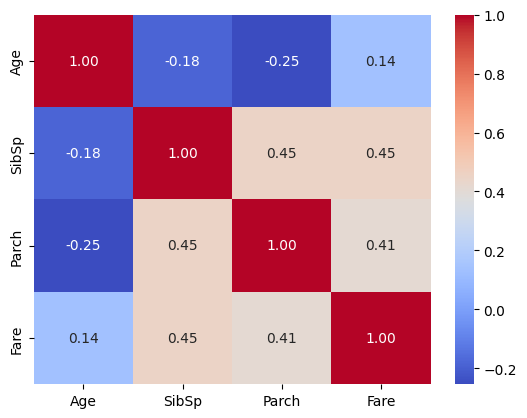

In [56]:
sns.heatmap(data[numeric_cols].corr(method='spearman'), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

A partir del estadístico de spearman observamos que las correlación no son fuertes. Aun faltando probar su significancia estadística

In [59]:
num_cols = data[numeric_cols]

In [64]:
from scipy.stats import spearmanr
import numpy as np

def get_spearman_pvalues(df):
    """Calcula matriz de p-valores para correlaciones de Spearman"""
    cols = df.columns
    n = len(cols)
    p_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i == j:
                p_matrix[i, j] = 0  # Diagonal siempre 0
            else:
                # Eliminar NaN para el cálculo
                x = df.iloc[:, i].dropna()
                y = df.iloc[:, j].dropna()
                # Encontrar índices comunes (sin NaN en ambas variables)
                common_idx = df[[cols[i], cols[j]]].dropna().index
                if len(common_idx) > 2:
                    corr, p_val = spearmanr(df.loc[common_idx, cols[i]], 
                                          df.loc[common_idx, cols[j]])
                    p_matrix[i, j] = p_val
                else:
                    p_matrix[i, j] = np.nan
    
    return pd.DataFrame(p_matrix, index=cols, columns=cols)

# Calcular matriz de p-valores
p_values_spearman = get_spearman_pvalues(num_cols)

# Crear lista de pares únicos (sin repetir)
pairs_data = []
cols = num_cols.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        var1, var2 = cols[i], cols[j]
        corr = corr_spearman.loc[var1, var2]
        p_val = p_values_spearman.loc[var1, var2]
        
        # Clasificar fuerza de correlación
        abs_corr = abs(corr)
        if abs_corr < 0.1:
            fuerza = "Muy débil"
        elif abs_corr < 0.3:
            fuerza = "Débil"
        elif abs_corr < 0.5:
            fuerza = "Moderada"
        elif abs_corr < 0.7:
            fuerza = "Fuerte"
        else:
            fuerza = "Muy fuerte"
            
        pairs_data.append({
            'Par_Variables': f"{var1} ↔ {var2}",
            'Spearman_ρ': corr,
            'p-valor': p_val,
            'Significativo_α05': 'Sí' if p_val < 0.05 else 'No',
            'Fuerza': fuerza
        })

# Crear DataFrame y ordenar por p-valor
correlations_df = pd.DataFrame(pairs_data)
correlations_df = correlations_df.sort_values('p-valor')

# Redondear valores para mejor legibilidad
correlations_df['Spearman_ρ'] = correlations_df['Spearman_ρ'].round(4)
correlations_df['p-valor'] = correlations_df['p-valor'].round(6)

display(correlations_df)


,Par_Variables,Spearman_ρ,p-valor,Significativo_α05,Fuerza
3,SibSp ↔ Parch,0.4500,0.000000,Sí,Moderada
4,SibSp ↔ Fare,0.4471,0.000000,Sí,Moderada
5,Parch ↔ Fare,0.4101,0.000000,Sí,Moderada
1,Age ↔ Parch,-0.2542,0.000000,Sí,Débil
0,Age ↔ SibSp,-0.1821,0.000001,Sí,Débil
2,Age ↔ Fare,0.1351,0.000296,Sí,Débil


Observamos que el p value indica que las correlaciones son significativa, sin embargo, debido a que el estadístico no es mayor a 0.5 no son correlaciones fuertes.

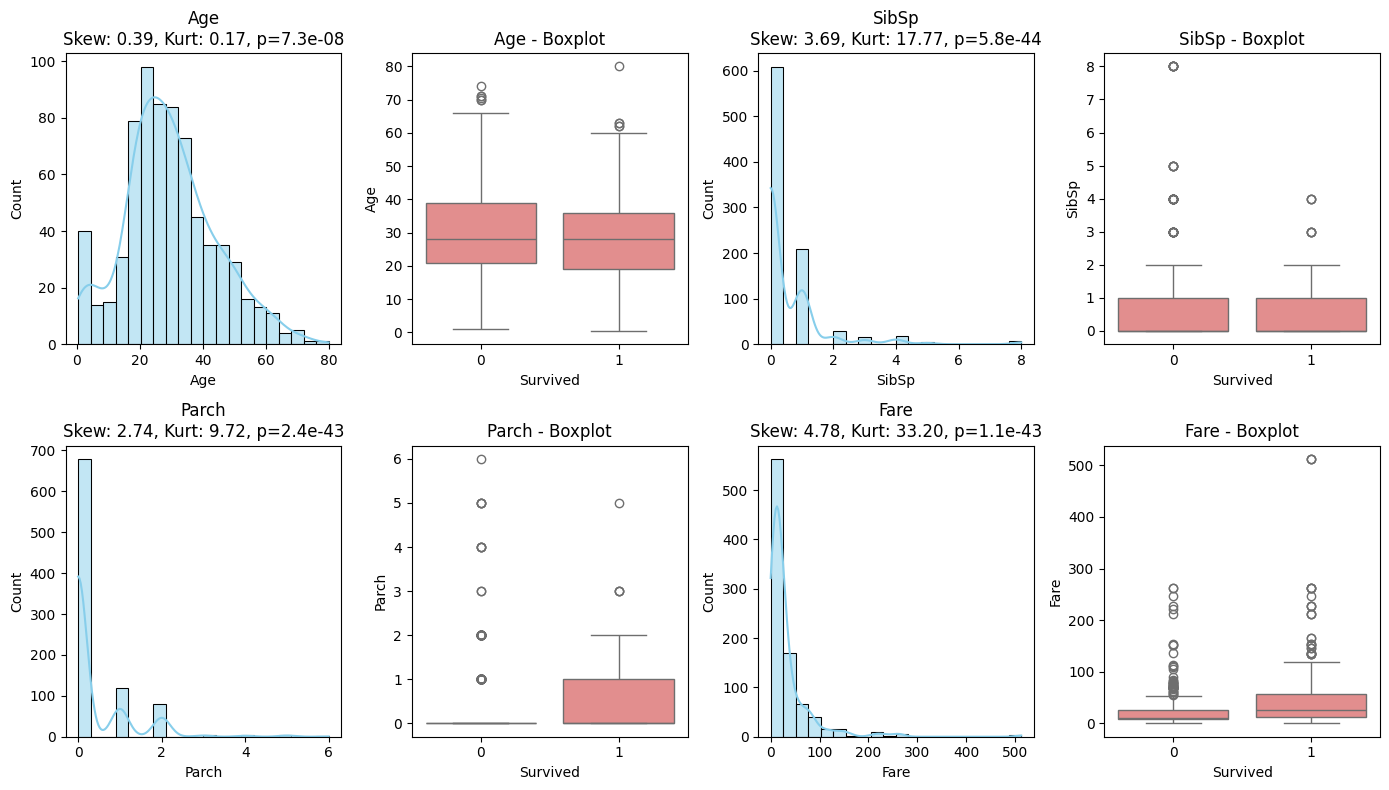

In [65]:
# Función para visualizar distribuciones numéricas y boxplots
def plot_numeric_distributions_by_class(data, numeric_cols):  
    cols_per_row = 2  # Número de columnas por fila
    n = len(numeric_cols)  # Total de columnas numéricas
    rows = -(-n // cols_per_row)  # Calcular número de filas (división hacia arriba)

    # Configuración de la figura
    plt.figure(figsize=(cols_per_row * 7, rows * 4))

    # Iterar sobre las columnas numéricas
    for idx, col in enumerate(numeric_cols, 1):
        # Calcular skew, kurtosis y realizar la prueba de normalidad (Shapiro)
        sk = skew(data[col].dropna())
        kt = kurtosis(data[col].dropna())
        _, p = shapiro(data[col].dropna())

        # Histograma y KDE
        plt.subplot(rows, cols_per_row * 2, idx * 2 - 1)
        sns.histplot(data[col], kde=True, bins=20, color="skyblue")
        plt.title(f"{col}\nSkew: {sk:.2f}, Kurt: {kt:.2f}, p={p:.2g}")

        # Boxplot para detectar atípicos
        plt.subplot(rows, cols_per_row * 2, idx * 2)
        sns.boxplot(x=data['Survived'], y=data[col], color="lightcoral")
        plt.title(f"{col} - Boxplot")

    # Ajustar los gráficos
    plt.tight_layout()
    plt.show()


plot_numeric_distributions_by_class(data, numeric_cols)

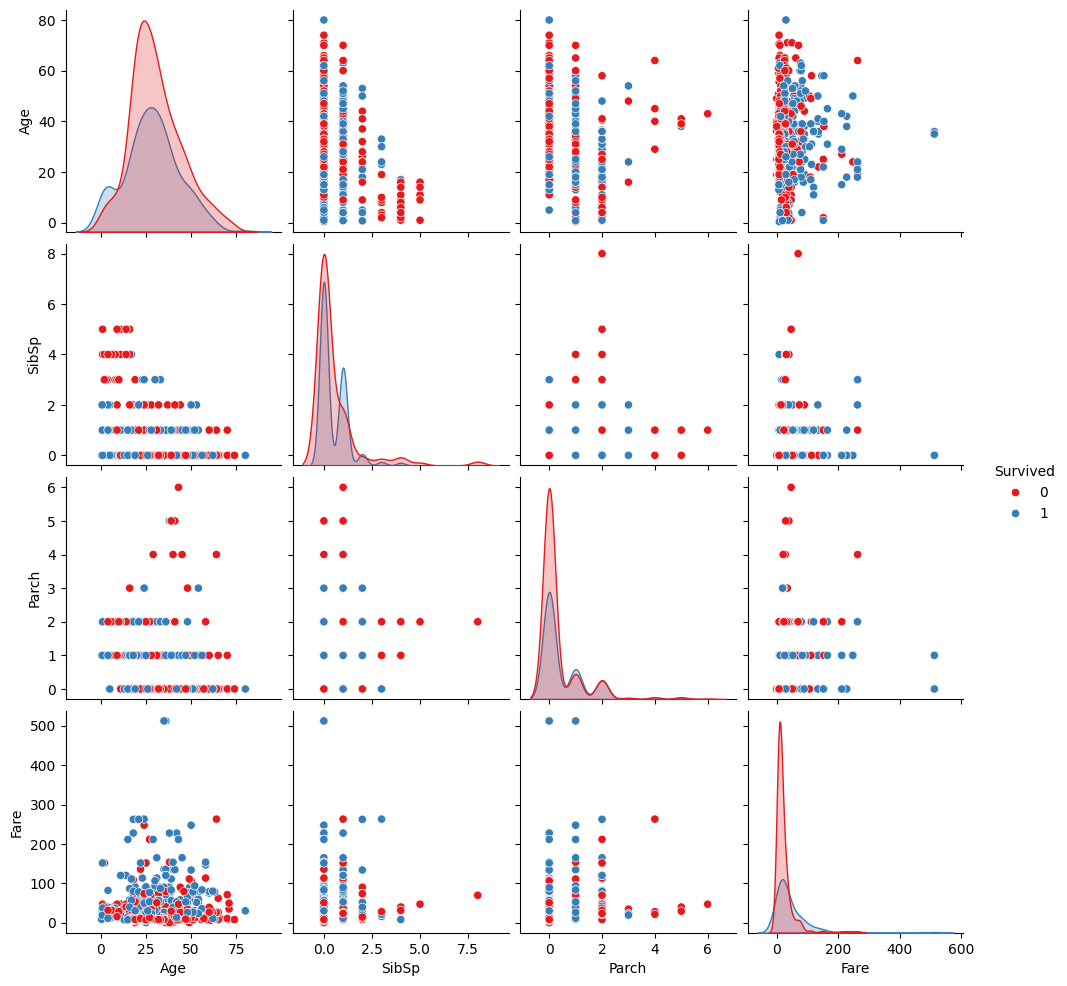

In [67]:
sns.pairplot(data, hue='Survived', vars=numeric_cols, palette='Set1')

## Multivariado cuantitativas vs cualitativas

**Nota:** Aunque parch y sibsp sean cuantitativas discretas, se mantendran como variables numéricas ya que se usará un random forest

In [68]:
from scipy.stats import ttest_ind, f_oneway, mannwhitneyu, kruskal

# --- t-test (Welch) y Mann–Whitney: Age por Survived (0 vs 1) ---
age_surv0 = data.loc[data["Survived"]==0, "Age"].dropna()
age_surv1 = data.loc[data["Survived"]==1, "Age"].dropna()

# Welch t-test (no asume varianzas iguales)
stat_t_age, p_t_age = ttest_ind(age_surv0, age_surv1, equal_var=False)

# Efecto (Cohen's d; pooled sd)
def cohens_d(x, y):
    n1, n2 = len(x), len(y)
    s1, s2 = x.var(ddof=1), y.var(ddof=1)
    s_p = np.sqrt(((n1-1)*s1 + (n2-1)*s2) / (n1+n2-2))
    return (x.mean() - y.mean()) / s_p

d_age = cohens_d(age_surv0, age_surv1)

# No paramétrico (Mann–Whitney U)
stat_mw_age, p_mw_age = mannwhitneyu(age_surv0, age_surv1, alternative="two-sided")

# --- t-test / Mann–Whitney: Fare por Sex (male vs female) ---
fare_male   = data.loc[data["Sex"]=="male", "Fare"].dropna()
fare_female = data.loc[data["Sex"]=="female", "Fare"].dropna()

stat_t_fare, p_t_fare = ttest_ind(fare_male, fare_female, equal_var=False)
d_fare = cohens_d(fare_male, fare_female)

stat_mw_fare, p_mw_fare = mannwhitneyu(fare_male, fare_female, alternative="two-sided")

# --- ANOVA y Kruskal–Wallis: Fare por Pclass (1,2,3) ---
classes = sorted(data["Pclass"].dropna().unique())
fare_groups = [data.loc[data["Pclass"]==c, "Fare"].dropna().values for c in classes]

# ANOVA (one-way)
stat_f, p_f = f_oneway(*fare_groups)

# Eta^2 desde F (aprox.)
k = len(fare_groups)
n = sum(len(g) for g in fare_groups)
eta2 = (stat_f * (k - 1)) / (stat_f * (k - 1) + (n - k))

# Kruskal–Wallis (no paramétrico)
stat_kw, p_kw = kruskal(*fare_groups)
                  

In [69]:
resultados_stats = pd.DataFrame({
    'Prueba': [
        'T-test (Age ~ Survived)',
        'Mann-Whitney (Age ~ Survived)', 
        'T-test (Fare ~ Sex)',
        'Mann-Whitney (Fare ~ Sex)',
        'ANOVA (Fare ~ Pclass)',
        'Kruskal-Wallis (Fare ~ Pclass)'
    ],
    'Estadístico': [
        stat_t_age,
        stat_mw_age,
        stat_t_fare,
        stat_mw_fare,
        stat_f,
        stat_kw
    ],
    'p-valor': [
        p_t_age,
        p_mw_age,
        p_t_fare,
        p_mw_fare,
        p_f,
        p_kw
    ],
    'Tamaño_efecto': [
        f"Cohen's d = {d_age:.3f}",
        f"U = {stat_mw_age}",
        f"Cohen's d = {d_fare:.3f}",
        f"U = {stat_mw_fare}",
        f"η² = {eta2:.3f}",
        f"H = {stat_kw:.3f}"
    ],
    'Significativo_α05': [
        'Sí' if p_t_age < 0.05 else 'No',
        'Sí' if p_mw_age < 0.05 else 'No',
        'Sí' if p_t_fare < 0.05 else 'No',
        'Sí' if p_mw_fare < 0.05 else 'No',
        'Sí' if p_f < 0.05 else 'No',
        'Sí' if p_kw < 0.05 else 'No'
    ]
})

resultados_stats['p-valor'] = resultados_stats['p-valor'].round(6)

display(resultados_stats)

,Prueba,Estadístico,p-valor,Tamaño_efecto,Significativo_α05
0,T-test (Age ~ Survived),2.046030,0.041190,Cohen's d = 0.157,Sí
1,Mann-Whitney (Age ~ Survived),65278.000000,0.160493,U = 65278.0,No
2,T-test (Fare ~ Sex),-5.077499,0.000001,Cohen's d = -0.388,Sí
3,Mann-Whitney (Fare ~ Sex),62175.000000,0.000000,U = 62175.0,Sí
4,ANOVA (Fare ~ Pclass),242.344157,0.000000,η² = 0.353,Sí
5,Kruskal-Wallis (Fare ~ Pclass),438.043703,0.000000,H = 438.044,Sí


La prueba no paramétrica demuestra que la edad no es un factor
determinante. Ambas pruebas muestran que hay una diferencia significativa en las
tarifas por sexo. Las clase del pasaje explica en gran medida la variación en tarifas